In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json
import os
import glob
from geopy.geocoders import Nominatim
import re
import pandas as pd
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import sklearn
from torchvision.transforms import InterpolationMode
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import math
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [2]:
from pathlib import Path
import argparse
import json
import os
import random
import signal
import sys
import time
import urllib

from torch import nn, optim
from torchvision import datasets, transforms
import torch
torch.cuda.empty_cache()

import resnet

import numpy as np
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json

import glob
from geopy.geocoders import Nominatim
import re
import pandas as pd
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import math
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True   #OTHERWISE TRUNCATED IMAGE FILE ERROR SOMEWHERE IN ENUMERATE(DATALOADER)!!!!

import resnet

import torchvision

from munkres import Munkres

import faiss

import torch
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
import torch.nn as nn

In [3]:
def get_y_preds(cluster_assignments, y_true, n_clusters):
    '''
    Computes the predicted labels, where label assignments now
    correspond to the actual labels in y_true (as estimated by Munkres)

    cluster_assignments:    array of labels, outputted by kmeans
    y_true:                 true labels
    n_clusters:             number of clusters in the dataset

    returns:    a tuple containing the accuracy and confusion matrix,
                in that order
    '''
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, cluster_assignments, labels=None)
    # compute accuracy based on optimal 1:1 assignment of clusters to labels
    cost_matrix = calculate_cost_matrix(confusion_matrix, n_clusters)
    indices = Munkres().compute(cost_matrix)
    kmeans_to_true_cluster_labels = get_cluster_labels_from_indices(indices)
    y_pred = kmeans_to_true_cluster_labels[cluster_assignments]
    return y_pred, confusion_matrix 

def calculate_cost_matrix(C, n_clusters):
    cost_matrix = np.zeros((n_clusters, n_clusters))

    # cost_matrix[i,j] will be the cost of assigning cluster i to label j
    for j in range(n_clusters):
        s = np.sum(C[:,j]) # number of examples in cluster i
        for i in range(n_clusters):
            t = C[i,j]
            cost_matrix[j,i] = s-t
    return cost_matrix

def get_cluster_labels_from_indices(indices):
    n_clusters = len(indices)
    clusterLabels = np.zeros(n_clusters)
    for i in range(n_clusters):
        clusterLabels[i] = indices[i][1]
    return clusterLabels

In [4]:
batch_size = 10

In [5]:
#DDP ATTEMPT

def init_distributed():

    # Initializes the distributed backend which will take care of synchronizing nodes/GPUs
    dist_url = "env://" # default

    # only works with torch.distributed.launch // torch.run
    rank = int(os.environ["RANK"])
    world_size = int(os.environ['WORLD_SIZE'])
    local_rank = int(os.environ['LOCAL_RANK'])
    dist.init_process_group(
            backend="nccl",
            init_method=dist_url,
            world_size=world_size,
            rank=rank)

    # this will make all .cuda() calls work properly
    torch.cuda.set_device(local_rank)

    # synchronizes all the threads to reach this point before moving on
    dist.barrier()
    
    print(world_size)

In [7]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#transforms = torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(224), torchvision.transforms.ToTensor(),normalize])
train_transforms = transforms.Compose(
            [   transforms.Resize(256),
                transforms.RandomResizedCrop(224),
                #transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ]
        )

val_transforms = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ]
        )


train_dataset = datasets.ImageFolder('./ImageNet/ILSVRC/Data/CLS-LOC/train' , train_transforms)
train_sampler = DistributedSampler(dataset=train_dataset, shuffle=True)                                                  
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            sampler=train_sampler, num_workers=10, pin_memory=True)
#trainloader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle = False)

val_dataset = datasets.ImageFolder('./ImageNet/ILSVRC/Data/CLS-LOC/val' , val_transforms)
val_sampler =DistributedSampler(dataset=val_dataset, shuffle=True)                                         
valloader = torch.utils.data.DataLoader(val_datset, batch_size=batch_size,
                                            shuffle=False, sampler=val_sampler, num_workers=10)
#valloader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle = False)

RuntimeError: Default process group has not been initialized, please make sure to call init_process_group.

In [6]:
torch.cuda.current_device()
torch.cuda.set_device(0)
print(torch.cuda.mem_get_info(torch.cuda.current_device()))
device = torch.cuda.current_device()

(12245794816, 12806062080)


In [7]:
supervised_model_pretrained = torchvision.models.resnet50(pretrained=True)
torch.save(supervised_model_pretrained.state_dict(), 'resnet50_imagenet_pretrained_supervised.pth')

In [8]:
backbone, embedding = resnet.__dict__['resnet50'](zero_init_residual=True)
state_dict = torch.load('resnet50_imagenet_pretrained_supervised.pth', map_location="cpu")
if "model" in state_dict:
    state_dict = state_dict["model"]
    state_dict = {key.replace("module.backbone.", ""): value for (key, value) in state_dict.items()}
backbone.load_state_dict(state_dict, strict=False)
backbone.cuda()

backbone = nn.SyncBatchNorm.convert_sync_batchnorm(backbone)

local_rank = int(os.environ['LOCAL_RANK'])
backbone = nn.parallel.DistributedDataParallel(backbone, device_ids=[local_rank])

ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [9]:
print(embedding)
backbone.eval()

2048


ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [10]:
labels_list = []
embeddings_list = []

labels_unseen_list = []
embeddings_unseen_list = []

with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(trainloader):
        
        #if i == 50000:
            #break
            
        if i%100 == 0:
            print(i)

            
        embedding = backbone(inputs.to(device))
        embeddings_list.append(embedding)
        labels_list.append(labels)

    


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200


KeyboardInterrupt: 

In [11]:
with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(valloader):
        
        #if i == 50000:
            #break
            
        if i%1000 == 0:
            print(i)
            
    
        embedding = backbone(inputs.to(device))
        embeddings_unseen_list.append(embedding)
        labels_unseen_list.append(labels)

0
1000
2000
3000
4000


In [12]:
#USE THIS IF BATCHSIZE>1
embeddings_seen_arr = np.zeros((len(trainloader)*batch_size-3, 2048))
counter = 0
for embedding in embeddings_list:
    if len(embedding) == 10:
        #print(len(embedding))
        embeddings_seen_arr[counter:counter+batch_size,:] = embedding.cpu().detach().numpy()
        counter += batch_size
    else:
        #print(len(embedding))
        embeddings_seen_arr[counter:counter+7,:] = embedding.cpu().detach().numpy()
        counter += 7

print(embeddings_seen_arr)
labels_seen_arr = np.zeros(len(trainloader)*batch_size-3)
counter = 0
for i in labels_list:
    if len(i) == 10:
        labels_seen_arr[counter:counter+batch_size] = i.detach().numpy()
    else:
        labels_seen_arr[counter:counter+7] = i.detach().numpy()
    counter += batch_size
print(np.unique(labels_seen_arr))

embeddings_unseen_arr = np.zeros((len(valloader)*batch_size, 2048))
counter = 0
for embedding in embeddings_unseen_list:
    embeddings_unseen_arr[counter:counter+batch_size,:] = embedding.cpu().detach().numpy()
    counter += batch_size

print(embeddings_unseen_arr)
labels_unseen_arr = np.zeros(len(valloader)*batch_size)
counter = 0
for i in labels_unseen_list:
    labels_unseen_arr[counter:counter+batch_size] = i.detach().numpy()
    counter += batch_size
print(np.unique(labels_unseen_arr))

embeddings_seen_arr = np.delete(embeddings_seen_arr,0,axis=0)
labels_seen_arr = np.delete(labels_seen_arr,0)
embeddings_unseen_arr = np.delete(embeddings_unseen_arr,0,axis=0)
labels_unseen_arr = np.delete(labels_unseen_arr,0)

[[2.05462649e-01 6.24961317e-01 1.06552474e-01 ... 4.79363427e-02
  2.51233071e-01 8.51763114e-02]
 [3.20454687e-01 7.22748399e-01 3.91381867e-02 ... 6.53433502e-02
  3.63435537e-01 2.37048596e-01]
 [1.31849155e-01 4.85993207e-01 5.74591048e-02 ... 7.40184560e-02
  4.56998110e-01 2.48788595e-01]
 ...
 [4.80764982e-04 2.68772274e-01 8.39343488e-01 ... 3.64980921e-02
  1.55609727e-01 8.47105384e-01]
 [5.14939189e-01 2.45923138e+00 8.97173345e-01 ... 2.05933586e-01
  1.99539721e-01 7.01217890e-01]
 [6.54005766e-01 1.52503222e-01 1.38447821e+00 ... 1.57990307e-01
  2.03023940e-01 9.25557792e-01]]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.

In [11]:
#embeddings_seen_arr = np.zeros((int(3*len(dataloader)/4), 2048))
#counter = 0
#for embedding in embeddings_list:
#    embeddings_seen_arr[counter,:] = embedding.cpu().detach().numpy()
##    counter += 1

#print(embeddings_seen_arr)
#labels_seen_arr = np.zeros(int(3*len(dataloader)/4))
#counter = 0
#for i in labels_list:
#    labels_seen_arr[counter] = i.detach().numpy()
#    counter += 1
#print(np.unique(labels_seen_arr))

#embeddings_unseen_arr = np.zeros((int(len(dataloader)/4), 2048))
#counter = 0
#for embedding in embeddings_unseen_list:
#    embeddings_unseen_arr[counter,:] = embedding.cpu().detach().numpy()
#    counter += 1

##print(embeddings_unseen_arr)
#labels_unseen_arr = np.zeros(int(len(dataloader)/4))
#counter = 0
#for i in labels_unseen_list:
#    labels_unseen_arr[counter] = i.detach().numpy()
#    counter += 1
#print(np.unique(labels_unseen_arr))

[[0.14875932 0.40740678 0.24900784 ... 0.42377618 0.62659913 0.26762429]
 [0.15100792 0.57644802 0.06908274 ... 0.32252085 1.0731976  0.4173148 ]
 [0.14548095 0.86708254 0.20886353 ... 0.20139341 1.05986702 0.19876178]
 ...
 [0.08778701 0.33687139 1.03078735 ... 0.24490468 0.23621872 0.15081446]
 [0.24522467 0.36625695 0.32675669 ... 0.25291982 0.05003487 0.1373997 ]
 [0.26443723 0.60494483 1.97403979 ... 0.34973338 0.31702667 0.34852833]]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109

In [13]:
# FASTER KNN IMPLEMENTATION!!!!

class FaissKNeighbors:
    def __init__(self, k):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes.astype(np.int64)])
        return predictions

In [14]:
n_neighbours = [20, 200]
for k in n_neighbours:
    
    #knn = KNeighborsClassifier(n_neighbors=k)
    knn = FaissKNeighbors(k = k)
    knn.fit(embeddings_seen_arr, labels_seen_arr)
    labels_predicted = knn.predict(embeddings_unseen_arr)

    print('Accuracy' + str(k) + ':', np.sum(labels_unseen_arr == labels_predicted)/len(labels_unseen_arr))
    #print('Accuracy:', knn.score(embeddings_unseen_arr, labels_unseen_arr))

Accuracy20: 0.7326746534930698
Accuracy200: 0.7158143162863257


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


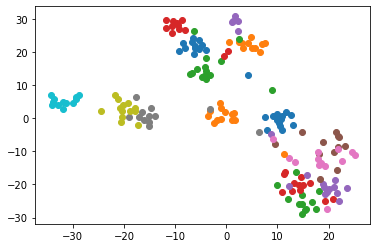

In [12]:
#JUST TRY DELETE LATER

#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE

#embeddings_unseen_arr_trial = embeddings_unseen_arr[0:180,:]
#labels_unseen_arr_trial = labels_unseen_arr[0:180]

#pca = PCA(n_components=2)
#pca.fit(embeddings_unseen_arr)
#print(pca.explained_variance_ratio_)

#embeddings_reduced = pca.transform(embeddings_unseen_arr)
#print(embeddings_reduced)

#u_labels = np.unique(labels_unseen_arr_trial)
#print(u_labels)

#embeddings_reduced = TSNE(n_components=2, learning_rate='auto',init='random', perplexity = 10.0).fit_transform(embeddings_unseen_arr_trial)

#for i in u_labels:
    
#    plt.scatter(embeddings_reduced[labels_unseen_arr_trial == i , 0] , embeddings_reduced[labels_unseen_arr_trial == i , 1] , label = i)

#plt.legend()
#plt.show()

In [13]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbours = [1, 3, 5, 10, 20, 30, 40, 50]

for k in n_neighbours:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(embeddings_seen_arr, labels_seen_arr)
    labels_predicted = knn.predict(embeddings_unseen_arr)

    #print('Accuracy' + str(k) + ':', np.sum(labels_unseen_arr == labels_predicted)/len(labels_unseen_arr))
    print('Accuracy:', knn.score(embeddings_unseen_arr, labels_unseen_arr))

Accuracy: 0.53104
Accuracy: 0.5348
Accuracy: 0.56032
Accuracy: 0.57928
Accuracy: 0.58632
Accuracy: 0.58416
Accuracy: 0.58
Accuracy: 0.57856


In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=1000, random_state=0).fit(embeddings_seen_arr)
labels_predicted = kmeans.predict(embeddings_unseen_arr)
print(labels_predicted)

from sklearn import metrics

print(metrics.rand_score(labels_unseen_arr, labels_predicted))

truth = labels_unseen_arr
pred=labels_predicted
print(np.sum( get_y_preds(pred, truth, 1000)[0] == truth )/len(truth) )

[328 199 199 ... 239 239 123]
0.9985074901992159
0.474


# VICREG

In [8]:
#TRY LIKE THIS
#backbone = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
#backbone.to(device)
#backbone.eval()

Using cache found in /local/home/bsoyuer/.cache/torch/hub/facebookresearch_vicreg_main


ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [ ]:
vicreg_model_pretrained = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
torch.save(vicreg_model_pretrained.state_dict(), 'resnet50_imagenet_pretrained_vicreg.pth')

In [29]:
backbone, embedding = resnet.__dict__['resnet50'](zero_init_residual=True)
state_dict = torch.load('resnet50_imagenet_pretrained_vicreg.pth', map_location="cpu")
if "model" in state_dict:
    state_dict = state_dict["model"]
    state_dict = {key.replace("module.backbone.", ""): value for (key, value) in state_dict.items()}
backbone.load_state_dict(state_dict, strict=False)
backbone.cuda()

ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [30]:
print(embedding)
backbone.eval()

2048


ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [ ]:
labels_list = []
embeddings_list = []

labels_unseen_list = []
embeddings_unseen_list = []

with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(trainloader):
        
        #if i == 50000:
            #break
            
        if i%100 == 0:
            print(i)
            
        
        embedding = backbone(inputs.to(device))
        embeddings_list.append(embedding)
        labels_list.append(labels)
        
        #torch.cuda.empty_cache()
            

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [ ]:
with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(valloader):
        
        #if i == 50000:
            #break
            
        if i%1000 == 0:
            print(i)
            
    
        embedding = backbone(inputs.to(device))
        embeddings_unseen_list.append(embedding)
        labels_unseen_list.append(labels)

In [ ]:
#USE THIS IF BATCHSIZE>1
embeddings_seen_arr = np.zeros((len(trainloader)*batch_size-3, 2048))
counter = 0
for embedding in embeddings_list:
    if len(embedding) == 10:
        #print(len(embedding))
        embeddings_seen_arr[counter:counter+batch_size,:] = embedding.cpu().detach().numpy()
        counter += batch_size
    else:
        #print(len(embedding))
        embeddings_seen_arr[counter:counter+7,:] = embedding.cpu().detach().numpy()
        counter += 7

print(embeddings_seen_arr)
labels_seen_arr = np.zeros(len(trainloader)*batch_size-3)
counter = 0
for i in labels_list:
    if len(i) == 10:
        labels_seen_arr[counter:counter+batch_size] = i.detach().numpy()
    else:
        labels_seen_arr[counter:counter+7] = i.detach().numpy()
    counter += batch_size
print(np.unique(labels_seen_arr))

embeddings_unseen_arr = np.zeros((len(valloader)*batch_size, 2048))
counter = 0
for embedding in embeddings_unseen_list:
    embeddings_unseen_arr[counter:counter+batch_size,:] = embedding.cpu().detach().numpy()
    counter += batch_size

print(embeddings_unseen_arr)
labels_unseen_arr = np.zeros(len(valloader)*batch_size)
counter = 0
for i in labels_unseen_list:
    labels_unseen_arr[counter:counter+batch_size] = i.detach().numpy()
    counter += batch_size
print(np.unique(labels_unseen_arr))

embeddings_seen_arr = np.delete(embeddings_seen_arr,0,axis=0)
labels_seen_arr = np.delete(labels_seen_arr,0)
embeddings_unseen_arr = np.delete(embeddings_unseen_arr,0,axis=0)
labels_unseen_arr = np.delete(labels_unseen_arr,0)

In [81]:
#for i in range(embeddings_seen_arr.shape[0]):
    #if len(np.unique(embeddings_seen_arr[i,:]))==1:
        #print('yes')
for i in range(embeddings_unseen_arr.shape[0]):
    if len(np.unique(embeddings_unseen_arr[i,:]))==1:
        print('yes_unseen')

In [35]:
#embeddings_seen_arr = np.zeros((len(trainloader), 2048))
#counter = 0
#for embedding in embeddings_list:
#    embeddings_seen_arr[counter,:] = embedding.cpu().detach().numpy()
#    counter += 1

#print(embeddings_seen_arr)
#labels_seen_arr = np.zeros(len(trainloader))
#counter = 0
#for i in labels_list:
#    labels_seen_arr[counter] = i.detach().numpy()
#    counter += 1
#print(np.unique(labels_seen_arr))

#embeddings_unseen_arr = np.zeros((len(valloader), 2048))
#counter = 0
#for embedding in embeddings_unseen_list:
#    embeddings_unseen_arr[counter,:] = embedding.cpu().detach().numpy()
#    counter += 1

#print(embeddings_unseen_arr)
#labels_unseen_arr = np.zeros(len(valloader))
#counter = 0
#for i in labels_unseen_list:
#    labels_unseen_arr[counter] = i.detach().numpy()
#    counter += 1
#print(np.unique(labels_unseen_arr))

ValueError: could not broadcast input array from shape (7,2048) into shape (10,2048)

In [82]:
# FASTER KNN IMPLEMENTATION!!!!

class FaissKNeighbors:
    def __init__(self, k):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes.astype(np.int64)])
        return predictions

In [83]:
from sklearn.neighbors import KNeighborsClassifier

#n_neighbours = [1, 3, 5, 10, 20, 30, 40, 50]
n_neighbours = [20, 200]
for k in n_neighbours:
    
    #knn = KNeighborsClassifier(n_neighbors=k)
    knn = FaissKNeighbors(k = k)
    knn.fit(embeddings_seen_arr, labels_seen_arr)
    labels_predicted = knn.predict(embeddings_unseen_arr)

    print('Accuracy' + str(k) + ':', np.sum(labels_unseen_arr == labels_predicted)/len(labels_unseen_arr))
    #print('Accuracy:', knn.score(embeddings_unseen_arr, labels_unseen_arr))

Accuracy20: 0.6193723874477489


KeyboardInterrupt: 

In [ ]:
#np.savetxt('embeddings_imagenet_seen_vicreg.txt', embeddings_seen_arr)
#np.savetxt('labels_imagenet_seen_vicreg.txt', labels_seen_arr, fmt='%d')


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


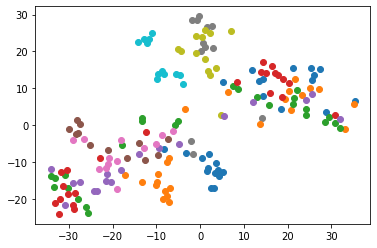

In [23]:
#JUST TRY DELETE LATER

#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE

#embeddings_unseen_arr_trial = embeddings_unseen_arr[0:180,:]
#labels_unseen_arr_trial = labels_unseen_arr[0:180]

#pca = PCA(n_components=2)
#pca.fit(embeddings_unseen_arr)
#print(pca.explained_variance_ratio_)

#embeddings_reduced = pca.transform(embeddings_unseen_arr)
#print(embeddings_reduced)

#u_labels = np.unique(labels_unseen_arr_trial)
#print(u_labels)

#embeddings_reduced = TSNE(n_components=2, learning_rate='auto',init='random', perplexity = 10.0).fit_transform(embeddings_unseen_arr_trial)

#for i in u_labels:
    
#    plt.scatter(embeddings_reduced[labels_unseen_arr_trial == i , 0] , embeddings_reduced[labels_unseen_arr_trial == i , 1] , label = i)

#plt.legend()
#plt.show()